# Baseline для  классификации видов животных по фотографии

Перед вами базовое решение, позволяющие обучить модель машинного обучения тому, какое животное находится на фотографии, а так же сформировать сабмит (посылку с решением) с результатами работы модели, чтобы можно было понять, насколько хорошо работает ваша модель.

Код ниже состоит из четырёх основных частей:
1. Установка и импорт библиотек, требуемых для работы
2. Подготовка данных для обучения модели ResNet18
3. Обучение базовой модели
5. Запуск модели и формирование сабмита.


## Установка и импорт библиотек

Прежде, чем приступать к дальнейшим шагам установите [Python](https://www.python.org/downloads/) на компьютер, с которым работаете. Решение проверялось на Python 3.9, но никто не запрещает использовать более новые версии. 

Совсем хорошо, если установите отдельное окружение c Python, используя, например [Miniconda](https://docs.anaconda.com/miniconda/) и [jupyter notebook](https://jupyter.org/install).  
После этого можно исполнять команды и код ниже.

Для обучения моделей нам понадобится Pytorch - фреймворк для машинного обучения.  
[Установите его для вашей платформы](https://pytorch.org/get-started/locally/), проверьте, что установлена версия с поддержкой GPU (видеокарт) с помощью кода ниже:

In [1]:
import torch

if torch.cuda.is_available():
    print("Все хорошо, установлена версия с поддержкой видеокарт")
else:
    print("Что-то не так, стоит torch с поддержкой только CPU (если у вас MacOS или так и задумано, то все нормально.")

Все хорошо, установлена версия с поддержкой видеокарт


In [2]:
# Установим библиотеки, требуемые для запуска решения
# !pip install scikit-learn Pillow torchvision matplotlib pandas tqdm 

In [3]:
import random
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as tt
from torchvision.transforms import v2

from PIL import Image
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet152_Weights
from tqdm import tqdm


# Зафиксируем сиды, чтобы обучение было воспроизводимым.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1001)

## Подготовка данных для обучения

In [4]:
# Мы подразумеваем, что данные будут лежать в рамках следующей структуры:
# .
# ├── baseline.ipynb
# └── data/
#     ├── train.csv
#     ├── train/
#     │   ├── ***.JPG
#     │   ├── ...
#     │   └── ***.JPG
#     └── test/
#         ├── ***.JPG
#         ├── ...
#         └── ***.JPG


base_path = Path("data/")
data = pd.read_csv(base_path / "train.csv")
images_path = base_path / "train"

# Разобъем данные на тренировочную и отложенную (на которой мы будем проверять качество работы) части
train, val = train_test_split(data, test_size=0.3, random_state=1)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Получилось примерно 29.3к картинок для тренировки и 12.5к картинок для подсчета метрик
print(train.shape, val.shape)

(28110, 3) (12048, 3)


In [5]:
# Что значат колонки:
# unified_class - имя класса кириллицей
# class_id - численный идентификатор класса для удобства работы
# image_name - название файла изобаржения в папке train.

data.head()

,unified_class,class_id,image_name
0,Кабан,2,0fa5f1cd824ca3705b654ada33437337.JPG
1,Изюбрь,3,da2969de9de9ca78eee5ba249e52ce89.JPG
2,Пятнистый олень,4,5b5d9c79cec42ea630d9f29ae59d2d6d.JPG
3,Рысь,11,e5dfc9f687530959332a2f8aa0594140.JPG
4,Сибирская косуля,6,50de65ad44e8dc71ed7f122eff3f2164.JPG


## Инициализация нужных объектов и обучение базовой модели

In [6]:
# В качестве стартовой модели возьмем ResNet18, предобученный на датасете ImageNet1K
# Но поменяем количество предсказываемых классов, так как вместо тысячи у нас десять классов.
# Можно было бы взять модель побольше и получить результаты лучше, но сейчас ограничимся ResNet152

class ResNet152(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Инициализируем модель
        self.model = torchvision.models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
        # Подменим классмификационный слой на наш собственный
        # self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
            )

    def forward(self, batch):
        inputs, _ = batch
        return self.model(inputs)

In [7]:
# Теперь подготовим класс датасет, в котором укажем насколько он большой (метод __len__) и
# как нам получить один элемент датасета (пару картинка - класс, которому эта картинка соответствует)

# Обращу внимание на transforms (они же аугментации) - способ, позволящий искусственно расширить датасет
# за счет того, что мы, обращаясь к датасету, каждый раз немного изменяем изображение разными способами (делаем из цветного черно-белое,
# вырезаем часть изображения, поворачиваем вокруг оси и т.д.). Часто это позволяет обучить модель более высокого качества, а так же сделать её
# устойчивее к непривычным ей данным

class AnimalsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, path_to_images: Path, transforms: tt.Compose) -> None:
        self.df = dataframe
        self.path_to_images = path_to_images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(self.path_to_images / row["image_name"]).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)
        return image, row["class_id"]

In [8]:
# Инициализируем агументации. В нашем примере я не использую ничего, кроме изменения разрешения изображения в квадрат 224 на 224 пикселя
# и нормализации (перевода пикселей от диапазона 0-255 к распределению с заданными средним и дисперсией).

train_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, 
                   saturation=0.2, hue=0.1),
    v2.RandomGrayscale(p=0.3),
    v2.RandomPerspective(distortion_scale=0.6, p=0.35),
    v2.RandomRotation(degrees=10),
    tt.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    tt.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = AnimalsDataset(train, images_path, transforms=train_transform)
val_dataset = AnimalsDataset(val, images_path, transforms=val_transform)


# Обратите внимание на 
# num_workers - во сколько отдельных потоков мы будем готовить данные (вызывать AnimalsDataset), можете поставить своё значение, посмотрев количество ядер на вашем компьютере
# batch_size - сколько картинок одновременно мы подадим на вход нашей модели.
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=0, shuffle=False)

In [ ]:
# Напишем код для обучения нашей нейронной сети:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Для обучения выбран девайс {}".format(device))

model = ResNet152(num_classes=data["unified_class"].nunique()).to(device)
# model.load_state_dict(torch.load("best_model.pth"))

criterion = nn.CrossEntropyLoss()

# Инициализируем функцию потерь (loss/criterion), а так же оптимизатор, который будет регулировать обновление весов нашей модели
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)
criterion = nn.CrossEntropyLoss()

# Переменные для визуализации метрик и функции потерь
train_losses = []
val_losses = []
# Для удобства оценивать качество модели будем той же метрику, что на лидерборде - F1 score
train_f1_scores = []
val_f1_scores = []

best_val_f1 = 0.9378
best_model_path = 'best_model.pth'

# Определим, сколько раз мы пройдёмся по всему датасету, прежде, чем закончим обучение модели и выберем лучшую версию
num_epochs = 150

# Напишем свой train_loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_true = []
    train_pred = []
    
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model((inputs, labels))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())
    
    train_f1 = f1_score(train_true, train_pred, average='macro')
    train_losses.append(running_loss / len(train_dataloader))
    train_f1_scores.append(train_f1)
    
    model.eval()
    val_running_loss = 0.0
    val_true = []
    val_pred = []
    
    # валидационный цикл, когда мы оцениваем качество работы модели на отложенной выборке
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model((inputs, labels))
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
    
    val_f1 = f1_score(val_true, val_pred, average='macro')
    val_losses.append(val_running_loss / len(valid_dataloader))
    val_f1_scores.append(val_f1)

    scheduler.step(val_running_loss / len(valid_dataloader))

    # если получившаяся модель лучше предыдущей, сохраним чекпоинт
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model saved with F1: {best_val_f1:.4f}')
    
    # выведем в консоль получившиеся результаты на отдельной эпохе
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1:.4f}')


Для обучения выбран девайс cuda


C:\Users\1003s\AppData\Local\Temp\ipykernel_10012\3072920121.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_unknown.pth"))


Epoch [1/150], Train Loss: 0.0300, Train F1: 0.9807, Val Loss: 0.1068, Val F1: 0.9363


100%|██████████| 377/377 [01:40<00:00,  3.73it/s]


Epoch [2/150], Train Loss: 0.0324, Train F1: 0.9806, Val Loss: 0.1103, Val F1: 0.9332


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [3/150], Train Loss: 0.0322, Train F1: 0.9802, Val Loss: 0.1086, Val F1: 0.9340


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [4/150], Train Loss: 0.0309, Train F1: 0.9810, Val Loss: 0.1093, Val F1: 0.9332


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [5/150], Train Loss: 0.0291, Train F1: 0.9839, Val Loss: 0.1080, Val F1: 0.9358


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [6/150], Train Loss: 0.0291, Train F1: 0.9809, Val Loss: 0.1075, Val F1: 0.9360


100%|██████████| 377/377 [01:40<00:00,  3.75it/s]


Epoch [7/150], Train Loss: 0.0321, Train F1: 0.9811, Val Loss: 0.1074, Val F1: 0.9354


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [8/150], Train Loss: 0.0298, Train F1: 0.9811, Val Loss: 0.1087, Val F1: 0.9371


100%|██████████| 377/377 [01:40<00:00,  3.75it/s]


Epoch [9/150], Train Loss: 0.0322, Train F1: 0.9838, Val Loss: 0.1106, Val F1: 0.9344


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [10/150], Train Loss: 0.0323, Train F1: 0.9814, Val Loss: 0.1087, Val F1: 0.9346


100%|██████████| 377/377 [01:40<00:00,  3.73it/s]


Epoch [11/150], Train Loss: 0.0311, Train F1: 0.9803, Val Loss: 0.1116, Val F1: 0.9358


100%|██████████| 377/377 [01:41<00:00,  3.70it/s]


Epoch [12/150], Train Loss: 0.0313, Train F1: 0.9821, Val Loss: 0.1087, Val F1: 0.9366


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [13/150], Train Loss: 0.0332, Train F1: 0.9822, Val Loss: 0.1097, Val F1: 0.9370


100%|██████████| 377/377 [01:41<00:00,  3.73it/s]


Epoch [14/150], Train Loss: 0.0326, Train F1: 0.9785, Val Loss: 0.1102, Val F1: 0.9348


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [15/150], Train Loss: 0.0304, Train F1: 0.9809, Val Loss: 0.1069, Val F1: 0.9373


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [16/150], Train Loss: 0.0306, Train F1: 0.9795, Val Loss: 0.1087, Val F1: 0.9340


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [17/150], Train Loss: 0.0327, Train F1: 0.9821, Val Loss: 0.1094, Val F1: 0.9360


100%|██████████| 377/377 [01:40<00:00,  3.74it/s]


Epoch [18/150], Train Loss: 0.0299, Train F1: 0.9811, Val Loss: 0.1081, Val F1: 0.9349


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [19/150], Train Loss: 0.0305, Train F1: 0.9818, Val Loss: 0.1090, Val F1: 0.9375


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


New best model saved with F1: 0.9384
Epoch [20/150], Train Loss: 0.0317, Train F1: 0.9826, Val Loss: 0.1093, Val F1: 0.9384


100%|██████████| 377/377 [01:39<00:00,  3.78it/s]


Epoch [21/150], Train Loss: 0.0325, Train F1: 0.9797, Val Loss: 0.1091, Val F1: 0.9359


100%|██████████| 377/377 [01:39<00:00,  3.77it/s]


Epoch [22/150], Train Loss: 0.0314, Train F1: 0.9824, Val Loss: 0.1074, Val F1: 0.9359


100%|██████████| 377/377 [01:39<00:00,  3.78it/s]


New best model saved with F1: 0.9399
Epoch [23/150], Train Loss: 0.0291, Train F1: 0.9846, Val Loss: 0.1077, Val F1: 0.9399


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [24/150], Train Loss: 0.0305, Train F1: 0.9815, Val Loss: 0.1092, Val F1: 0.9363


100%|██████████| 377/377 [01:39<00:00,  3.79it/s]


Epoch [25/150], Train Loss: 0.0296, Train F1: 0.9820, Val Loss: 0.1076, Val F1: 0.9372


100%|██████████| 377/377 [01:40<00:00,  3.77it/s]


Epoch [26/150], Train Loss: 0.0317, Train F1: 0.9812, Val Loss: 0.1076, Val F1: 0.9361


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [27/150], Train Loss: 0.0320, Train F1: 0.9799, Val Loss: 0.1103, Val F1: 0.9349


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [28/150], Train Loss: 0.0311, Train F1: 0.9832, Val Loss: 0.1114, Val F1: 0.9337


100%|██████████| 377/377 [01:39<00:00,  3.78it/s]


Epoch [29/150], Train Loss: 0.0307, Train F1: 0.9801, Val Loss: 0.1083, Val F1: 0.9372


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [30/150], Train Loss: 0.0305, Train F1: 0.9820, Val Loss: 0.1118, Val F1: 0.9358


100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


Epoch [31/150], Train Loss: 0.0315, Train F1: 0.9819, Val Loss: 0.1103, Val F1: 0.9330


100%|██████████| 377/377 [01:40<00:00,  3.77it/s]


Epoch [32/150], Train Loss: 0.0314, Train F1: 0.9828, Val Loss: 0.1104, Val F1: 0.9376


100%|██████████| 377/377 [01:42<00:00,  3.67it/s]


Epoch [33/150], Train Loss: 0.0330, Train F1: 0.9816, Val Loss: 0.1096, Val F1: 0.9340


100%|██████████| 377/377 [01:42<00:00,  3.66it/s]


Epoch [34/150], Train Loss: 0.0306, Train F1: 0.9829, Val Loss: 0.1112, Val F1: 0.9373


  1%|          | 6/879 [00:04<10:45,  1.35it/s]


KeyboardInterrupt: 

In [12]:
optimizer.param_groups[0]["lr"]

3.2000000000000018e-09

In [13]:
best_val_f1

0.9399065731155232

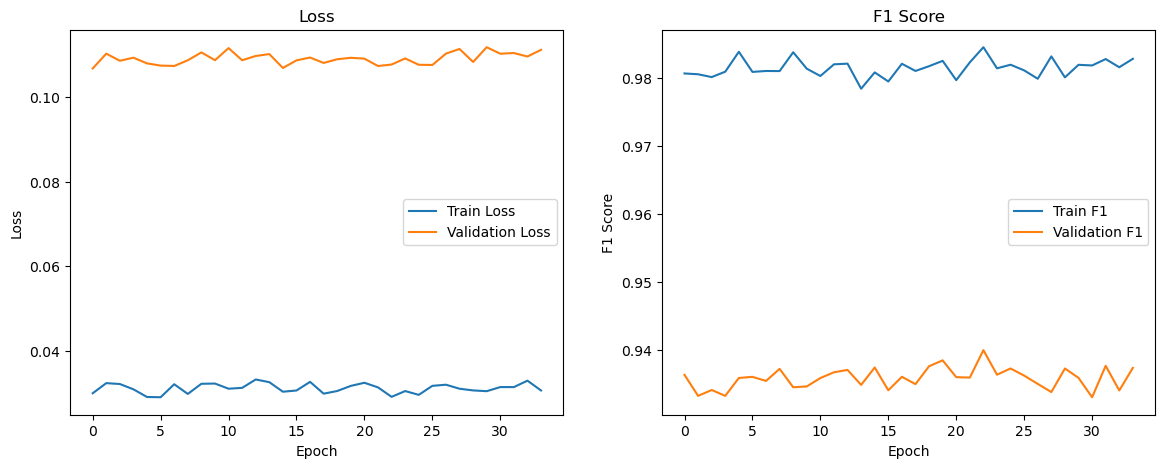

In [14]:
# После эксперимента важно оценить полученные кривые обучения, чтобы сформировать новые гипотезы
# Визуализируем их!

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.show()

## Инференс модели и формирование сабмита

In [17]:
# У нас есть обученная модель! Теперь сделаем инференс модели на тестовых данных и подготовим файл сабмита!

# Немного перепишем наш датасет, ведь для тестовой части у нас нет меток классов, но нам нужны имена файлов для сабмита
class InferenceDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)
        return image, image_path.name


# Тут важно не ошибиться и не использовать тренировочные трансформы
infer_transform = v2.Compose([
    v2.Resize((224, 224)),
    tt.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Найдем все тестовые картинки
test_image_paths = base_path / "test"
test_image_paths = list(test_image_paths.glob("*.JPG"))

infer_dataset = InferenceDataset(test_image_paths, transforms=infer_transform)
infer_dataloader = DataLoader(infer_dataset, batch_size=64, shuffle=False)

# Инициализируем нашу модель и загрузим в неё лучшие после эксперимента веса 
model = ResNet152(num_classes=data["unified_class"].nunique()).to(device)
model.load_state_dict(torch.load(best_model_path))

# Не забудем перевести модель в режим предсказания, а не обучения.
model.eval()

# Для ускорения инференса будем подавать в модель картинки батчами (по несколько картинок за раз) и сохраним предсказанные метки классов.
results = []
for images, image_names in tqdm(infer_dataloader):
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model((images, None))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    
    for image_name, pred_class in zip(image_names, preds):
        results.append({"image_name": image_name, "predicted_class": pred_class})



# Для удобства объединим все пары "имя файла - предсказанный класс" в датафрейм (таблицу) с колонками image_name, predicted_class
df_results = pd.DataFrame(results)

# Вывод DataFrame
print(df_results.head())

C:\Users\1003s\AppData\Local\Temp\ipykernel_10012\1367229511.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_unknown.pth"))

                             image_name  predicted_class
0  000028438ed4f212bfcf4f1c3b4b1aab.JPG                0
1  000a25d7a14f15f2bb6349640653cdbc.JPG               12
2  000eb8747b0cd8f848c2f98048b5445d.JPG               11
3  0010bd149e23b169ffc16e5627ece2bf.JPG               15
4  0011a31e779ec92689aad0e0139bec7c.JPG                4


In [18]:
# Сохраним результат предсказаний в файл и всё! Можно отправлять!
df_results.to_csv("submission.csv", index=False)